In [28]:
import os
import openai
import sys
from typing import Optional
sys.path.append("..")
import matplotlib.pyplot as plt

import numpy as np

In [18]:
def get_chatcompletion(
    prompt,
    model: int = "gpt-3.5-turbo",
    temperature: float = 0.0,
    max_tokens: int = 512,
    top_p: float = 1.0,
    n: int = 1,
):
    messages = [
        {"role": "user",
         "content": prompt},
    ]
    
    response = openai.ChatCompletion.create(
        model = model,
        messages = messages,
        max_tokens = max_tokens,
        temperature = temperature,
        top_p = top_p,
        n = n,   
    )
    
    return response

def extract_best(response_obj):
    return response_obj["choice"]

# OpenAI

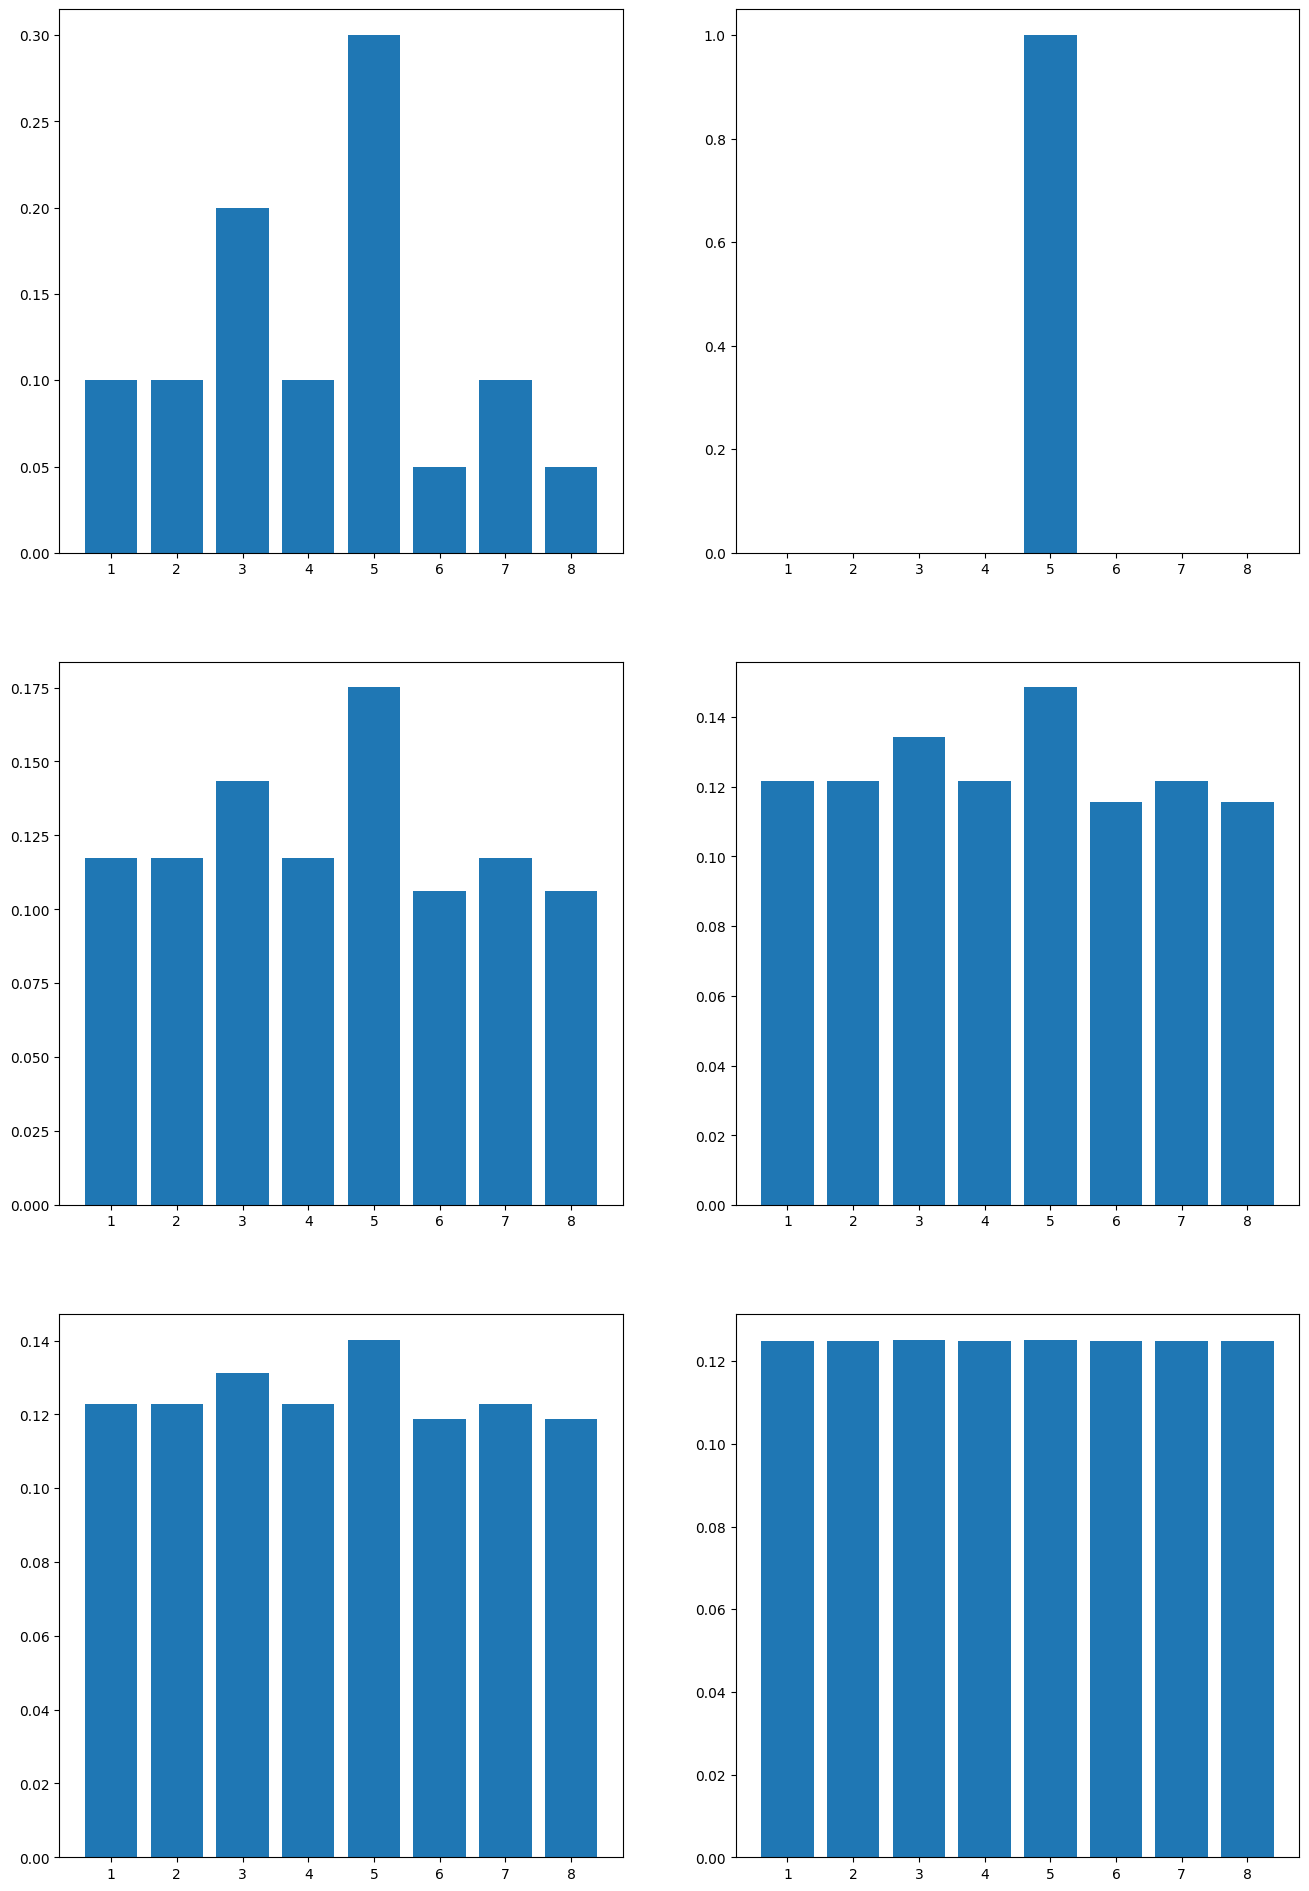

In [33]:
p = np.array([0.1, 0.1, 0.2, 0.1, 0.3, 0.05, 0.1, 0.05])
ts = [0.01, 0.5, 1, 1.5, 100]

plt.figure(figsize=(16, 24))

plt.subplot(3,2,1)
plt.bar(list(range(1, len(p) + 1)), p)

plot_idx = 2
for t in ts:
    exp_p = np.exp(p/t)
    sum_exp = exp_p.sum()
    softmax_p = exp_p/sum_exp
    plt.subplot(3,2,plot_idx)
    plt.bar(list(range(1, len(p) + 1)), softmax_p)
    plot_idx += 1
      

In [34]:
if os.getenv("OPENAI_API_KEY"):
    openai.api_key = os.environ["OPENAI_API_KEY"]
else:
    openai.api_key = "Input Key"

openai.Model.list()

AuthenticationError: Incorrect API key provided: Input Key. You can find your API key at https://platform.openai.com/account/api-keys.

In [19]:
prompt = "Generate two random adjectives. Return as two plain uncased words separated by newline"

output_response = get_chatcompletion(prompt,
                                     temperature = 1,
                                     n = 3)
print(output_response)

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "slick\nfuzzy",
        "role": "assistant"
      }
    },
    {
      "finish_reason": "stop",
      "index": 1,
      "message": {
        "content": "smooth\nfierce",
        "role": "assistant"
      }
    },
    {
      "finish_reason": "stop",
      "index": 2,
      "message": {
        "content": "playful\nglossy",
        "role": "assistant"
      }
    }
  ],
  "created": 1683087774,
  "id": "chatcmpl-7ByIwwJEtT8lVqXIT26rAhZrSOpNX",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 14,
    "prompt_tokens": 24,
    "total_tokens": 38
  }
}
